<h1> Скачиваем набор данных

In [1]:
!nvidia-smi

Fri Jul 11 12:54:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import shutil
import time
import matplotlib.pyplot as plt
import os

Откроем датасет, которые получили после предварительной обработки текстовых данных

In [ ]:
directory_to_delete = "/kaggle/working/chest-xrays-indiana-university/images/images_normalized"

if os.path.isdir(directory_to_delete):
    try:
        shutil.rmtree(directory_to_delete)
        print(f"Folder '{directory_to_delete}' and its contents deleted successfully.")
    except OSError as e:
        print(f"Error: {e.filename} - {e.strerror}.")
else:
    print(f"Folder '{directory_to_delete}' does not exist.")

Error: /kaggle/working/chest-xrays-indiana-university/images/images_normalized - Directory not empty.


In [3]:
# Source directory
source_dir = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized"

# Destination directory
destination_dir = "/kaggle/working/chest-xrays-indiana-university/images/images_normalized"

shutil.copytree(source_dir, destination_dir)

'/kaggle/working/chest-xrays-indiana-university/images/images_normalized'

In [4]:
df = pd.read_csv("/kaggle/input/merged-df-pkl/final.csv")
df.head()

,Frontal,Lateral,MeSH,Problems,indication,findings,impression
0,1_IM-0001-4001.dcm.png,1_IM-0001-3001.dcm.png,normal,normal,positive tb test,the cardiac silhouette and mediastinum size ar...,normal chest
1,2_IM-0652-1001.dcm.png,2_IM-0652-2001.dcm.png,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,preop bariatric surgery,borderline cardiomegaly midline sternotomy enl...,no acute pulmonary findings
2,3_IM-1384-1001.dcm.png,3_IM-1384-2001.dcm.png,normal,normal,rib pain after a steps this pain to r back r e...,NaN,no displaced rib fractures pneumothora or pleu...
3,4_IM-2050-1001.dcm.png,4_IM-2050-2001.dcm.png,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...",with,there are diffuse bilateral interstitial and a...,bullous emphysema and interstitial fibrosis p...
4,5_IM-2117-1003002.dcm.png,5_IM-2117-1004003.dcm.png,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,chest and nasal congestion,the cardiomediastinal silhouette and pulmonary...,no acute cardiopulmonary abnormality


In [5]:
df = df[["Frontal", "Lateral", "findings"]]
df = df.rename(columns={"Frontal": "image_1",
                        "Lateral": "image_2"
                        })

In [6]:
df.head()

,image_1,image_2,findings
0,1_IM-0001-4001.dcm.png,1_IM-0001-3001.dcm.png,the cardiac silhouette and mediastinum size ar...
1,2_IM-0652-1001.dcm.png,2_IM-0652-2001.dcm.png,borderline cardiomegaly midline sternotomy enl...
2,3_IM-1384-1001.dcm.png,3_IM-1384-2001.dcm.png,NaN
3,4_IM-2050-1001.dcm.png,4_IM-2050-2001.dcm.png,there are diffuse bilateral interstitial and a...
4,5_IM-2117-1003002.dcm.png,5_IM-2117-1004003.dcm.png,the cardiomediastinal silhouette and pulmonary...


In [7]:
df.shape

(3913, 3)

Проверим на пустоты

In [8]:
df.isnull().sum()

image_1       0
image_2       0
findings    525
dtype: int64

In [9]:
df.dropna(inplace=True)

## Подготовим текст

In [10]:
df_1 = df.copy()

Добавим `<start>` & `<end>`

In [11]:
df_1["findings"] = "<start> " + df_1["findings"] + " <end>"

In [12]:
df_1.head()

,image_1,image_2,findings
0,1_IM-0001-4001.dcm.png,1_IM-0001-3001.dcm.png,<start> the cardiac silhouette and mediastinum...
1,2_IM-0652-1001.dcm.png,2_IM-0652-2001.dcm.png,<start> borderline cardiomegaly midline sterno...
3,4_IM-2050-1001.dcm.png,4_IM-2050-2001.dcm.png,<start> there are diffuse bilateral interstiti...
4,5_IM-2117-1003002.dcm.png,5_IM-2117-1004003.dcm.png,<start> the cardiomediastinal silhouette and p...
5,6_IM-2192-1001.dcm.png,6_IM-2192-2001.dcm.png,<start> heart size and mediastinal contour are...


Для изображений укажем путь

In [13]:
df_1["image_1"] = "/kaggle/working/chest-xrays-indiana-university/images/images_normalized/" + df_1["image_1"]
df_1["image_2"] = "/kaggle/working/chest-xrays-indiana-university/images/images_normalized/" + df_1["image_2"]

df_1.head()

,image_1,image_2,findings
0,/kaggle/working/chest-xrays-indiana-university...,/kaggle/working/chest-xrays-indiana-university...,<start> the cardiac silhouette and mediastinum...
1,/kaggle/working/chest-xrays-indiana-university...,/kaggle/working/chest-xrays-indiana-university...,<start> borderline cardiomegaly midline sterno...
3,/kaggle/working/chest-xrays-indiana-university...,/kaggle/working/chest-xrays-indiana-university...,<start> there are diffuse bilateral interstiti...
4,/kaggle/working/chest-xrays-indiana-university...,/kaggle/working/chest-xrays-indiana-university...,<start> the cardiomediastinal silhouette and p...
5,/kaggle/working/chest-xrays-indiana-university...,/kaggle/working/chest-xrays-indiana-university...,<start> heart size and mediastinal contour are...


Запишем данные из таблицы в списки

In [14]:
med_report = []
image_paths = []

for i in tqdm(range (0,df.shape [0])):
    image_paths.append(df_1.iloc[i].loc['image_1'])
    med_report.append(df_1.iloc[i].loc['findings'])
    image_paths.append(df_1.iloc[i].loc['image_2'])
    med_report.append(df_1.iloc[i].loc['findings'])

  0%|          | 0/3388 [00:00<?, ?it/s]

In [15]:
train_captions = []
train_captions = med_report

## Создание модели

Используется механизм внимания с *энкодером* и *декодером*.

**Энкодер** пропускает признаки изображения через полносвязный слой. **Декодер** генерирует подписи к этим признакам.

Вместо того чтобы обучать модель с нуля, мы использовали DenseNet121 с предварительно обученными весами [CheXNet](https://www.kaggle.com/datasets/theewok/chexnet-keras-weights)

In [16]:
import tensorflow as tf

2025-07-11 12:59:49.485473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752238789.892697      75 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752238790.006398      75 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [17]:
CHEXNET_WEIGHTS = """/kaggle/input/chexnet-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5"""

image_model = tf.keras.applications.densenet.DenseNet121(include_top=True,
                                                         classes=14,
                                                         weights=CHEXNET_WEIGHTS)
new_input = image_model.input
hidden_layer = image_model.layers[-3].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
# image_features_extract_model.summary()

I0000 00:00:1752238812.608035      75 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752238812.608768      75 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


___

<h1> Подготовка модели

In [18]:
# base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False,
#                                                             weights="imagenet",
#                                                             input_shape=(299, 299, 3))

base_model = tf.keras.applications.densenet.DenseNet121(include_top=False,
                                                        weights="imagenet",
                                                        # classes=14,
                                                        input_shape=(299, 299, 3))

# base_model = tf.keras.applications.densenet.DenseNet121(include_top=True,
#                                                         weights=CHEXNET_WEIGHTS,
#                                                         classes=14,
#                                                         input_shape=(299, 299, 3))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
base_model.trainable = True

Создание модели

In [20]:
image_model = base_model

In [21]:
# def load_image(image_path):
#     img = tf.io.read_file(image_path)
#     img = tf.io.decode_jpeg(img, channels=3)
#     img = tf.keras.layers.Resizing(299, 299)(img)
#     img = tf.keras.applications.inception_v3.preprocess_input(img)
#     return img, image_path

def load_image(image_path):
    # 1) Читаем файл и декодируем JPEG в uint8
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)

    # 2) Изменяем размер (по-прежнему uint8)
    img = tf.keras.layers.Resizing(299, 299)(img)

    # 3) Кастим в float32, чтобы preprocess_input сработал корректно
    img = tf.cast(img, tf.float32)

    # 4) Нормализуем под InceptionV3: (0–255) → (–1 … +1)
    img = tf.keras.applications.densenet.preprocess_input(img)

    return img, image_path

Модель извлечения признаков изображения

In [22]:
new_input = image_model.input
hidden_layer = image_model.layers[-3].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

Get unique names

In [23]:
encode_train = sorted(set(image_paths))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1,  batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

  0%|          | 0/396 [00:00<?, ?it/s]

I0000 00:00:1752238822.886282      75 cuda_dnn.cc:529] Loaded cuDNN version 90300


In [24]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

max_length = 100
vocabulary_size = 9000

tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_sequence_length=max_length
)

tokenizer.adapt(caption_dataset)

In [25]:
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

Создание отображения слов на токены и токенов на слова

In [26]:
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

Разделение данных на train & test выборки

In [27]:
import collections
import random

In [28]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(image_paths, cap_vector):
    img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

# for train split
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

# for validation split
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [29]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(5411, 5411, 1365, 1365)

<h1>Создание окончательных данных

In [30]:
batch_size = 64
buffer_size = 1000
embedding_dim = 512
units = 1024
num_steps = len(img_name_train) // batch_size
features_shape = 2560
attention_features_shape = 81

Загрузка numpy файлов

In [31]:
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8') + '.npy')
    return img_tensor, cap

In [32]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(buffer_size).batch(batch_size)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

<h1> Создание модели

In [33]:
class CustomAttention(tf.keras.Model):
    def __init__(self, units):
        super(CustomAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                            self.W2(hidden_with_time_axis)))


        # For unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [34]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [35]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        # 1) создаём GRUCell без return_sequences/return_state
        gru_cell = tf.keras.layers.GRUCell(
            self.units,
            recurrent_initializer='glorot_uniform'
        )
        # 2) оборачиваем его в RNN — и получаем нужную функциональность:
        self.gru = tf.keras.layers.RNN(
            gru_cell,
            return_sequences=True,
            return_state=True,   # вернёт (outputs, state)
            unroll=False         # важно: unroll=False (по-умолчанию) – значит, через tf.while_loop
        )
        
        # self.gru = tf.keras.layers.GRU(self.units,
        #                             return_sequences=True,
        #                             return_state=True,
        #                             recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = CustomAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention model
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))

        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [36]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [37]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')

In [38]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [39]:
checkpoint_path = "/kaggle/working/"

ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [40]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

<h2> Обучение

In [41]:
loss_plot = []

In [42]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initialize the hidden state for each batch
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([word_to_index('')] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

<h3>5 эпох

In [43]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy() / int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')

    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss / num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.2362
Epoch 1 Loss 1.221192
Time taken for 1 epoch 434.55 sec

Epoch 2 Batch 0 Loss 0.8385
Epoch 2 Loss 0.884613
Time taken for 1 epoch 152.55 sec

Epoch 3 Batch 0 Loss 0.8757
Epoch 3 Loss 0.804458
Time taken for 1 epoch 152.29 sec

Epoch 4 Batch 0 Loss 0.6807
Epoch 4 Loss 0.744045
Time taken for 1 epoch 152.32 sec

Epoch 5 Batch 0 Loss 0.7056
Epoch 5 Loss 0.703020
Time taken for 1 epoch 152.34 sec



Графики после 5 эпох обучения

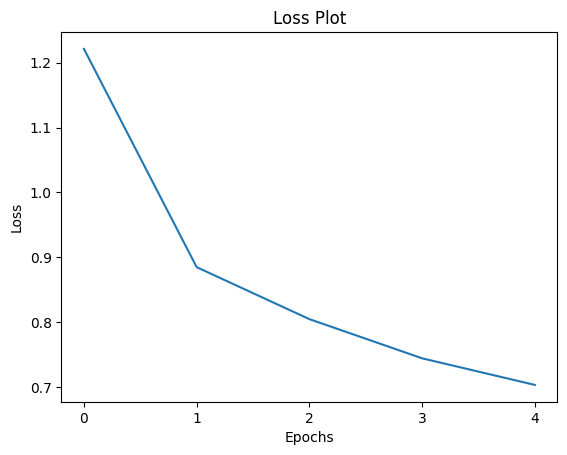

In [44]:
plt.plot(loss_plot)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Plot")
plt.xticks(range(0, len(loss_plot)))
plt.show()

<h3> Добавим еще 10 эпох. Итого 15

In [53]:
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy() / int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss / num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec\n')

Epoch 1 Batch 0 Loss 0.7179
Epoch 1 Loss 0.669416
Time taken for 1 epoch 153.38 sec

Epoch 2 Batch 0 Loss 0.5115
Epoch 2 Loss 0.641277
Time taken for 1 epoch 152.36 sec

Epoch 3 Batch 0 Loss 0.5690
Epoch 3 Loss 0.617648
Time taken for 1 epoch 152.41 sec

Epoch 4 Batch 0 Loss 0.5607
Epoch 4 Loss 0.597948
Time taken for 1 epoch 152.27 sec

Epoch 5 Batch 0 Loss 0.5875
Epoch 5 Loss 0.578109
Time taken for 1 epoch 152.38 sec

Epoch 6 Batch 0 Loss 0.3987
Epoch 6 Loss 0.559010
Time taken for 1 epoch 152.67 sec

Epoch 7 Batch 0 Loss 0.5646
Epoch 7 Loss 0.541014
Time taken for 1 epoch 152.55 sec

Epoch 8 Batch 0 Loss 0.5807
Epoch 8 Loss 0.526356
Time taken for 1 epoch 152.39 sec

Epoch 9 Batch 0 Loss 0.4329
Epoch 9 Loss 0.510674
Time taken for 1 epoch 152.44 sec

Epoch 10 Batch 0 Loss 0.4574
Epoch 10 Loss 0.494987
Time taken for 1 epoch 152.52 sec



Графики после 15 эпох обучения

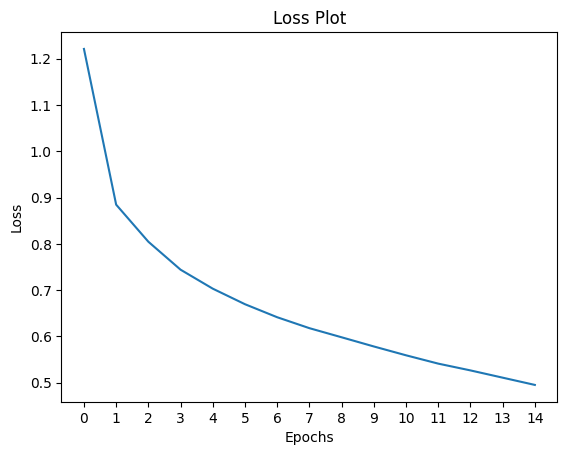

In [54]:
plt.plot(loss_plot)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Plot")
plt.xticks(range(0, len(loss_plot)))
plt.show()

In [70]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy() / int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')

    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss / num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec\n')

Epoch 1 Batch 0 Loss 0.4677
Epoch 1 Loss 0.482889
Time taken for 1 epoch 153.02 sec

Epoch 2 Batch 0 Loss 0.4498
Epoch 2 Loss 0.471327
Time taken for 1 epoch 156.58 sec

Epoch 3 Batch 0 Loss 0.3774
Epoch 3 Loss 0.454836
Time taken for 1 epoch 156.80 sec

Epoch 4 Batch 0 Loss 0.4335
Epoch 4 Loss 0.443700
Time taken for 1 epoch 156.71 sec

Epoch 5 Batch 0 Loss 0.4324
Epoch 5 Loss 0.430205
Time taken for 1 epoch 156.63 sec



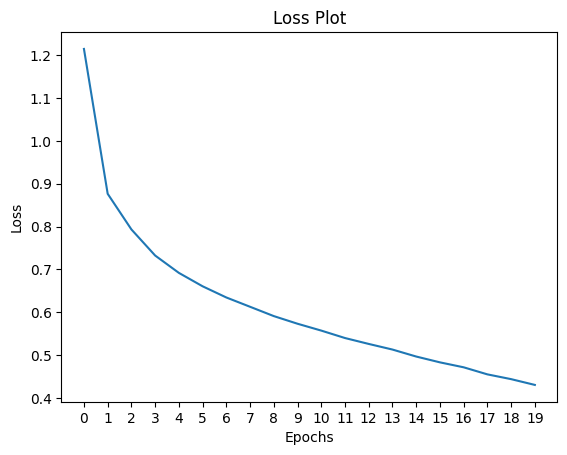

In [71]:
plt.plot(loss_plot)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Plot")
plt.xticks(range(0, len(loss_plot)))
plt.show()

<h2> Подпись

In [45]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [46]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(200, 200))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (80, 80))
        grid_size = max(int(np.ceil(len_result/2)), 1)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    # plt.tight_layout()
    plt.show()

In [47]:
!pip install rouge-score bert-score pycocoevalcap -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 16.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.7 MB/s eta 0:00:00:00:0100:01


In [48]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [49]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from bert_score import score as bert_score_fn
from nltk.translate.meteor_score import meteor_score
from nltk.translate.meteor_score import single_meteor_score
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

chencherry = SmoothingFunction()

rid 820
BLEU-1: 0.0929
BLEU-2: 0.0683
BLEU-3: 0.0522
BLEU-4: 0.0402
ROUGE-1: 0.5484
ROUGE-2: 0.3333
ROUGE-L: 0.4516
METEOR score: 0.3520

CIDEr score: 0.0000
Real report:  heart size and mediastinal contours appear within normal limits pulmonary vascularity is within normal limits no focal consolidation suspicious pulmonary opacity pneumothora or definite pleural effusion visualized osseous structures appear intact
Predicted report:  there is marked narrowing of the spine or mediastinal contours appear within normal limits no pneumothora or pleural effusion there is no focal infiltrate pleural effusion or pneumothora or pleural effusion seen cardiomediastinal silhouette is grossly unremarkable no focal consolidations no pleural effusion or pneumothora stable appearance of the base representing chronic appearing left chest there is no focal airspace opacity pleural effusion or pneumothora heart mediastinum is unremarkable there is no evidence of focal infiltrates or focal opacity the la

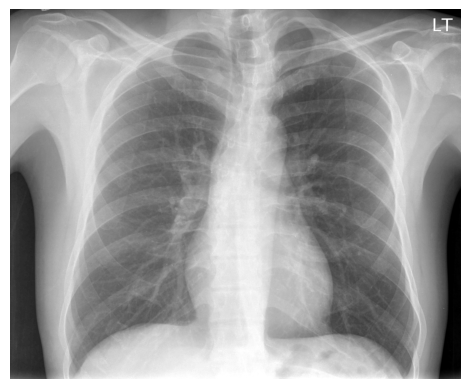

In [61]:
# rid = np.random.randint(0, len(img_name_val))
rid = 820
print('rid', rid)

image = img_name_val[rid]
img = plt.imread(image)

plt.figure()
plt.imshow(img, cmap = "gray")
plt.axis(False)

real_caption = [tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]]

result, attention_plot = evaluate(image)
rem = ['startseq', 'start', 'end', 'endseq']

real_caption  = [x for x in real_caption if x not in rem]
result = [x for x in result if x not in rem]

weights = [(1, 0, 0, 0),   # BLEU-1
           (0.5, 0.5, 0, 0), # BLEU-2
           (0.33, 0.33, 0.33, 0), # BLEU-3
           (0.25, 0.25, 0.25, 0.25)] # BLEU-4

bleu_scores = []
for i, weight in enumerate(weights, start=1):
    score = sentence_bleu([result], real_caption, weights=weight, smoothing_function=SmoothingFunction().method5)
    print(f"BLEU-{i}: {score:.4f}")

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = scorer.score(' '.join(result), ' '.join(real_caption))
print(f"ROUGE-1: {rouge_scores['rouge1'].precision:.4f}")
print(f"ROUGE-2: {rouge_scores['rouge2'].precision:.4f}")
print(f"ROUGE-L: {rouge_scores['rougeL'].precision:.4f}")

meteor_score = single_meteor_score(real_caption, result)
print(f'METEOR score: {meteor_score:.4f}')

cand_str = " ".join(result)
ref_str  = " ".join(real_caption)
# P, R, F1 = bert_score_fn([cand_str], [ref_str],
#                          lang="en", idf=True, verbose=False)
# print(f"\nBERTScore: {P.mean().item():.4f}  R: {R.mean().item():.4f}  F1: {F1.mean().item():.4f}")

refs  = {0: [ref_str]}
cands = {0: [cand_str]}

cider_scorer = Cider()
cider_score, _     = cider_scorer.compute_score(refs, cands)
print(f"\nCIDEr score: {cider_score:.4f}")

# spice_scorer = Spice()
# spice_score, _     = spice_scorer.compute_score(refs, cands)
# print(f"SPICE score: {spice_score:.4f}")

print('Real report: ', ' '.join([i for i in real_caption]))
print('Predicted report: ', ' '.join(result))

<h2>Расчет качества модели

In [ ]:
# BLEU 1-4

index = len(img_name_val)
cols = ['image', 'real', 'pred', 'bleu_1', 'bleu_2', 'bleu_3', 'bleu_4', 'rouge_1', 'rouge_l']
dat = pd.DataFrame(columns=cols)

# Инициализируем переменные для суммирования метрик
bleu_scores = [0] * len(weights)

# Создаем список весов для BLEU-1 до BLEU-4
weights = [
    (1, 0, 0, 0),    # BLEU-1
    (0.5, 0.5, 0, 0),  # BLEU-2
    (0.33, 0.33, 0.33, 0),  # BLEU-3
    (0.25, 0.25, 0.25, 0.25)  # BLEU-4
]

rouge_1 = 0
rouge_l = 0
bleu_1_scores = []
bleu_2_scores = []
bleu_3_scores = []
bleu_4_scores = []

nums = 50

dfs = []

for j in range(nums):
    image = img_name_val[j]

    real_caption = [tf.compat.as_text(index_to_word(i).numpy())
                            for i in cap_val[j] if i not in [0]]

    result, attention_plot = evaluate(image)

    # removing the start and end tags we initially added
    rem = ['startseq', 'start', 'end', 'endseq']

    real_caption  = [x for x in real_caption if x not in rem]
    result  = [x for x in result if x not in rem]

    print(f'Real report: {" ".join([i for i in real_caption])}')
    print(f'Predicted report: {" ".join(result)}')

    chencherry = SmoothingFunction()
    bleu_scores = [0] * len(weights)

    for i, weight in enumerate(weights):
        bleu_scores[i] = sentence_bleu([result], real_caption, weights=weight,
                                       smoothing_function=chencherry.method5)
    bleu_1_scores.append(bleu_scores[0])
    bleu_2_scores.append(bleu_scores[1])
    bleu_3_scores.append(bleu_scores[2])
    bleu_4_scores.append(bleu_scores[3])

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(' '.join(result), ' '.join(real_caption))
    rouge_1 += rouge_scores['rouge1'].precision
    rouge_l += rouge_scores['rougeL'].precision

    real_cap =  ' '.join([i for i in real_caption])
    pred_cap = ' '.join(result)

    temp_df = pd.DataFrame({'image': [image],
                            'real': [real_cap],
                            'pred': [pred_cap],
                            'bleu_1': [bleu_scores[0]],
                            'bleu_2': [bleu_scores[1]],
                            'bleu_3': [bleu_scores[2]],
                            'bleu_4': [bleu_scores[3]],
                            'rouge_1': [rouge_scores['rouge1'].precision],
                            'rouge_l': [rouge_scores['rougeL'].precision]})

    dfs.append(temp_df)

    print('BLEU_1 score:', bleu_scores[0])
    print('BLEU_2 score:', bleu_scores[1])
    print('BLEU_3 score:', bleu_scores[2])
    print('BLEU_4 score:', bleu_scores[3])
    print("ROUGE-1 score:", rouge_scores['rouge1'].precision)
    print("ROUGE-L score:", rouge_scores['rougeL'].precision)

    print(f"{'*' * 100}")

average_bleu_1 = sum(bleu_1_scores) / nums
average_bleu_2 = sum(bleu_2_scores) / nums
average_bleu_3 = sum(bleu_3_scores) / nums
average_bleu_4 = sum(bleu_4_scores) / nums

# Вывод средних значений метрик BLEU
print(f"Average BLEU-1 score on the test data is {average_bleu_1}")
print(f"Average BLEU-2 score on the test data is {average_bleu_2}")
print(f"Average BLEU-3 score on the test data is {average_bleu_3}")
print(f"Average BLEU-4 score on the test data is {average_bleu_4}")
print(f"Average rouge_1 score on the test data is {rouge_1 / nums}")
print(f"Average rouge_l score on the test data is {rouge_l / nums}")

dat = pd.concat(dfs, ignore_index=True)

# Сохраняем DataFrame в файл CSV
dat.to_csv('/content/drive/MyDrive/shikha version/data/real_vs_predicted.csv', index=False)

Real report: indications male with pneumonia findings heart size within normal limits there is focal left lateral base airspace disease there is a mm nodular opacity in the right midlung no pneumothora no pleural effusion no displaced rib fractures there is an apparent deformity of the right humeral surgical neck this is not seen on the comparison correlate clinically with history of fracture impressions left base airspace disease and nodular opacity in the right midlung
Predicted report: indications syncopal episode findings the trachea is midline negative for pneumothora pleural effusion or focal airspace consolidation heart size and pulmonary vascularity are within normal limits impressions no acute cardiopulmonary abnormality of lung cancer no months findings the heart size and mediastinal contour are within normal limits the lungs are clear impressions negative for adenopathy no acute osseous abnormality bilateral pulmonary arteries changes of retained contrast at hours findings h

In [ ]:
# index = len(img_name_val)
# cols = ['image', 'real', 'pred', 'bleu', 'rouge_1', 'rouge_l']
# dat = pd.DataFrame(columns=cols)

# bl = 0
# rouge_1 = 0
# rouge_l = 0

# df_predicted_res = pd.DataFrame()

# nums = 50

# for j in range(nums):
#     image = img_name_val[j]

#     real_caption = [tf.compat.as_text(index_to_word(i).numpy())
#                             for i in cap_val[j] if i not in [0]]

#     result, attention_plot = evaluate(image)

#     # removing the start and end tags we initially added
#     rem = ['startseq', 'start', 'end', 'endseq']

#     real_caption  = [x for x in real_caption if x not in rem]
#     result  = [x for x in result if x not in rem]

#     print('Real report: ', ' '.join([i for i in real_caption]))
#     print('Predicted report: ', ' '.join(result))

#     chencherry = SmoothingFunction()
#     bl += sentence_bleu([result], real_caption, weights=(1, 0, 0, 0), smoothing_function=chencherry.method5)
#     scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
#     rouge_scores = scorer.score(' '.join(result), ' '.join(real_caption))
#     rouge_1 += rouge_scores['rouge1'].precision
#     rouge_l += rouge_scores['rougeL'].precision

#     print('Bleu score: ', sentence_bleu([result], real_caption, weights=(1, 0, 0, 0), smoothing_function=chencherry.method5))
#     print("ROUGE-1 score:", rouge_scores['rouge1'].precision)
#     print("ROUGE-L score:", rouge_scores['rougeL'].precision)

#     real_cap =  ' '.join([i for i in real_caption])
#     pred_cap = ' '.join(result)
#     dat = dat.append({'image': image,
#                       'real': real_cap,
#                       'pred': pred_cap,
#                       'bleu': sentence_bleu([result], real_caption, weights=(1, 0, 0, 0), smoothing_function=chencherry.method5),
#                       'rouge_1': rouge_scores['rouge1'].precision,
#                       'rouge_l': rouge_scores['rougeL'].precision}, ignore_index=True)
#     print('*' * 100)

# print("Average bleu score on the test data is ", bl / nums)
# print("Average rouge_1 score on the test data is ", rouge_1 / nums)
# print("Average rouge_l score on the test data is ", rouge_l / nums)

# dat.to_csv('/content/drive/MyDrive/shikha version/data/real_vs_predicted.csv')


In [ ]:
prediction = pd.read_csv('/content/drive/MyDrive/shikha version/data/real_vs_predicted.csv')
prediction

,image,real,pred,bleu_1,bleu_2,bleu_3,bleu_4,rouge_1,rouge_l
0,/content/images/images_normalized/1855_IM-0555...,indications male with pneumonia findings heart...,indications syncopal episode findings the trac...,0.490277,0.305438,0.190763,0.112036,0.356164,0.191781
1,/content/images/images_normalized/119_IM-0128-...,indications right arm numbness rightsided ches...,indications female with and smoking and findin...,0.358128,0.223685,0.140825,0.083065,0.383333,0.233333
2,/content/images/images_normalized/2417_IM-0961...,indications chest pain findings stable cardiom...,indications male with chest pain nonproductive...,0.104533,0.066191,0.039963,0.023106,0.419355,0.387097
3,/content/images/images_normalized/443_IM-2078-...,indications positive ppd findings heart size a...,indications loss of transmetatarsal carcinoma ...,0.217261,0.153326,0.109578,0.076143,0.567568,0.324324
4,/content/images/images_normalized/1210_IM-0142...,indications with scheduled hip replacement sur...,indications findings the lungs remain clear de...,0.505940,0.346912,0.236824,0.153672,0.430769,0.230769
5,/content/images/images_normalized/357_IM-1753-...,indications woman with shortness of breath fin...,indications chest pain findings cardiac and me...,0.547278,0.358324,0.241112,0.155734,0.302632,0.223684
6,/content/images/images_normalized/2702_IM-1170...,indications difficulty breathing chest pain fo...,indications pain findings lungs are mildly inc...,0.132282,0.078423,0.046379,0.026490,0.466667,0.333333
7,/content/images/images_normalized/113_IM-0086-...,indications chest pain findings the heart and ...,indications female with chest pain findings ca...,0.307583,0.192469,0.119218,0.069756,0.375000,0.250000
8,/content/images/images_normalized/36_IM-1776-1...,indications female with chest pain rule out pn...,indications diminished breath sounds findings ...,0.319062,0.217502,0.154605,0.108592,0.568182,0.454545
9,/content/images/images_normalized/738_IM-2296-...,indications chest pain findings the heart and ...,indications female dyspnea shortness of breath...,0.058008,0.034499,0.020417,0.011672,0.461538,0.307692
